# 02750 HW1

## Exercise 3 Passive vs Active Learning (Regression)

#### Imports

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import warnings
import random
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

#### Data

In [83]:
column_names = ["mcv", "alkphos", "sgpt", "sgot", "gammagt", "drinks", "selector"]
data = pd.read_csv("liver+disorders/bupa.data", header=None, names=column_names) # 517 rows x 13 columns 
data = data.drop("selector", axis =1)

In [84]:
data 

,mcv,alkphos,sgpt,sgot,gammagt,drinks
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0
...,...,...,...,...,...,...
340,99,75,26,24,41,12.0
341,96,69,53,43,203,12.0
342,98,77,55,35,89,15.0
343,91,68,27,26,14,16.0


In [85]:
random_seeds = []
for i in range(5):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 10))
random_seeds

[7, 3, 1, 10, 5]

#### Passive Learning

In [86]:
def regression_passive_learning(d, seed):
    # Store the average MSE from cross validation on training data
    cross_fold_mse= [] 
    # Store average test MSE using Unseen data
    all_test_mse = []
    
    # d = shuffle(data, random_state=seed)

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
    
    # Run the loop while the sample_data includes 50% of the original data
    while len(sample_data) <= len(d) /2 :
        # Store MSE from individual fold 
        fold_mse = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            regressor = RandomForestRegressor(random_state=None)
            regressor.fit(features_train, labels_train)
            y_pred = regressor.predict(features_test)
            mse = mean_squared_error(labels_test, y_pred)
            fold_mse.append(mse)
            
        # Get the average cross fold MSE on the training data
        avg_cross_fold_mse = np.mean(fold_mse)
        cross_fold_mse.append(avg_cross_fold_mse)

        # Predict 80% of the data 
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        # Get the MSE score on the unseen data 
        reg = RandomForestRegressor(random_state=None)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        all_test_mse.append(test_mse) # 46 points

        # Move one instance from test data to training data 
        instance_to_add = remaining_data.sample(n=1)
        sample_data = pd.concat([sample_data, instance_to_add], ignore_index=True) 
        remaining_data = remaining_data.drop(instance_to_add.index)
        

    return cross_fold_mse, all_test_mse


#### Active Learning 

In [87]:
def sigma_squared(predictions, true_vals, num_features):
    diff_sqrd = np.sum((true_vals - predictions) ** 2)
    den = len(true_vals) - num_features - 1
    return diff_sqrd/den

In [88]:
def calc_variances(train_X, test_x, sig_sqr):
    # Calculate (X'X)^-1
    XtX_inv = np.linalg.inv(train_X.T @ train_X)
    variances = []
    for i in test_x.values:
        prod = i @ (XtX_inv) @ (i.T)
        prod = sig_sqr * prod
        variances.append(prod)
    return variances

In [89]:
import numpy as np

def regression_active_learning(d, seed):
    # Store average cross fold validation MSE on the training data
    cross_fold_mse = [] 
    # Store test MSE on the unseen data
    all_test_mse = []
    # d = shuffle(data, random_state=seed)

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]

    # Run the loop until the sample data includes 50% of the original data 
    while len(sample_data) <= len(d) / 2:
        # Store accuracy score from individual fold
        fold_mse = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            model = RandomForestRegressor(random_state=None)
            model.fit(features_train, labels_train)
            y_pred = model.predict(features_test)
            mse = mean_squared_error(labels_test, y_pred)
            fold_mse.append(mse)
            
        # Get the average of the fold accuracies on the training data
        avg_cross_fold_acc = np.mean(fold_mse)
        cross_fold_mse.append(avg_cross_fold_acc)

        # Training a model on the current sample data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        # Getting predictions on the train data to calculate sigma squared
        temp_mod = RandomForestRegressor(random_state=None)
        temp_mod.fit(X_train, y_train)
        train_preds_for_sigma_sqrd = temp_mod.predict(X_train) 
        
        # Calculate sigma squared (σ^2)
        sig_sqr = sigma_squared(train_preds_for_sigma_sqrd, y_train, 5)
      
        # Predicting labels for the remaining data
        mod = RandomForestRegressor(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        all_test_mse.append(test_mse) 

        # Calculate variances using the test data
        variances = calc_variances(X_train, X_test, sig_sqr)

        # Get the index of the data point with the highest variance 
        highest_variance_index = np.argmax(variances)
        instance_to_add = remaining_data.iloc[[highest_variance_index]]
       
        # Adding the selected instance to the sample data
        sample_data = pd.concat([sample_data, instance_to_add], ignore_index=True)
        remaining_data = remaining_data.drop(instance_to_add.index)
        
    return cross_fold_mse, all_test_mse


#### Performance Plot of Passive and Active Learning (using Uncertainty Sampling) on a Classification Task

In [90]:
# Running Passive Learning 
cv_mse_passive = dict()
test_mse_passive = dict() 

for seed in tqdm(random_seeds):
    cv_mse, test_mse = regression_passive_learning(data, seed)

    cv_mse_passive[seed] = cv_mse 
    test_mse_passive[seed] = test_mse 

train_mse = list(cv_mse_passive.values())
train_avg_mse_passive = np.mean(train_mse, axis=0)

test_mse = list(test_mse_passive.values())
test_avg_mse_passive = np.mean(test_mse, axis=0)


# Running Active Learning 
cv_mse_active = dict()
test_mse_active = dict() 

for seed in tqdm(random_seeds):
    cv_mse, test_mse = regression_active_learning(data, seed)
    cv_mse_active[seed] = cv_mse 
    test_mse_active[seed] = test_mse 

train_mse = list(cv_mse_active.values())
train_avg_mse_active = np.mean(train_mse, axis=0)

test_mse = list(test_mse_active.values())
test_avg_mse_active = np.mean(test_mse, axis=0)


100%|██████████| 5/5 [03:26<00:00, 41.32s/it]


/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_41762/4181333377.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, train_avg_mse_passive, yerr=np.std(train_avg_mse_passive), label='Cross Validation MSE Passive Learning', fmt='-o', linestyle='-')
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_41762/4181333377.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, test_avg_mse_passive, yerr=np.std(test_avg_mse_passive),label='Unobserved Set MSE Passive Learning', fmt='-o', linestyle='-')
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_41762/4181333377.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (->

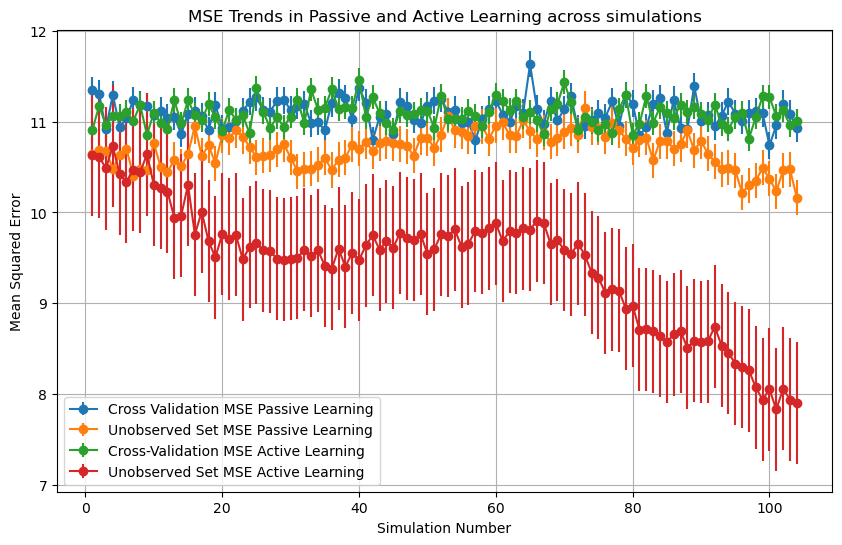

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x_values = list(range(1, 105))

plt.errorbar(x_values, train_avg_mse_passive, yerr=np.std(train_avg_mse_passive), label='Cross Validation MSE Passive Learning', fmt='-o', linestyle='-')
plt.errorbar(x_values, test_avg_mse_passive, yerr=np.std(test_avg_mse_passive),label='Unobserved Set MSE Passive Learning', fmt='-o', linestyle='-')
plt.errorbar(x_values, train_avg_mse_active, yerr=np.std(train_avg_mse_active),label='Cross-Validation MSE Active Learning', fmt='-o', linestyle='-')
plt.errorbar(x_values, test_avg_mse_active, yerr=np.std(test_avg_mse_active),label='Unobserved Set MSE Active Learning', fmt='-o', linestyle='-')
plt.title('MSE Trends in Passive and Active Learning across simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

